In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
%matplotlib inline

In [15]:
CPI=pd.read_excel('/Users/zackienzle/CBA/data/AUCPI Index.xlsx', header=5)
IOCR = pd.read_excel('/Users/zackienzle/CBA/data/RBACOR Index.xlsx', header=5)
GTAUD1YR = pd.read_excel('/Users/zackienzle/CBA/data/GTAUD1YR Corp.xlsx', header=5)
GTAUD2YR = pd.read_excel('/Users/zackienzle/CBA/data/GTAUD2YR Corp.xlsx', header=5)
GTAUD3YR = pd.read_excel('/Users/zackienzle/CBA/data/GTAUD3YR Corp.xlsx', header=5)
GTAUD5YR = pd.read_excel('/Users/zackienzle/CBA/data/GTAUD5YR Corp.xlsx', header=5)
GTAUD10YR = pd.read_excel('/Users/zackienzle/CBA/data/GTAUD10YR Corp.xlsx', header=5)
GTAUD1YR

cols = {
    'CPI': CPI,
    'IOCR': IOCR,
    'GTAUD1YR': GTAUD1YR,
    'GTAUD2YR': GTAUD2YR,
    'GTAUD3YR': GTAUD3YR,
    'GTAUD5YR': GTAUD5YR,
    'GTAUD10YR': GTAUD10YR
}

px_last_series = {
    name: data['PX_LAST']
    for name, data in cols.items() if 'PX_LAST' in data.columns
}

df = pd.DataFrame(px_last_series).dropna().iloc[::-1]
print(df)
df.info()

       CPI  IOCR  GTAUD1YR  GTAUD2YR  GTAUD3YR  GTAUD5YR  GTAUD10YR
306    3.7  4.32     4.083     3.778     3.626     3.662      4.091
305    3.8  4.32     4.052     3.727     3.638     3.671      4.008
304    3.9  4.32     4.073     3.750     3.608     3.638      4.009
303    4.0  4.32     4.057     3.722     3.589     3.621      3.974
302    4.1  4.32     4.046     3.705     3.583     3.621      3.951
..     ...   ...       ...       ...       ...       ...        ...
4    137.4  4.09     3.517     3.383     3.425     3.655      4.333
3    138.8  4.09     3.470     3.322     3.366     3.594      4.278
2    139.1  4.09     3.471     3.317     3.357     3.570      4.239
1    139.4  4.09     3.508     3.375     3.413     3.622      4.289
0    140.7  4.09     3.555     3.441     3.476     3.685      4.360

[307 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 307 entries, 306 to 0
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     -----

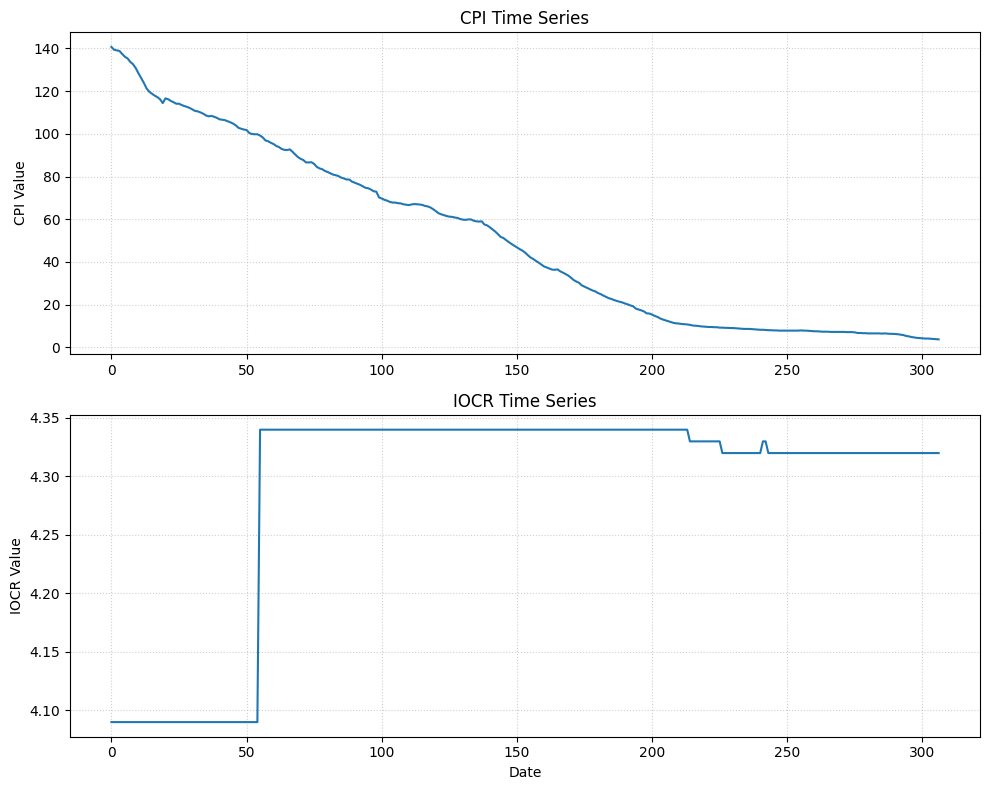

In [16]:
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(211)
ax1.plot(df.index, df["CPI"])
ax1.set_title("CPI Time Series")
ax1.set_ylabel("CPI Value")
ax1.grid(True, linestyle=':', alpha=0.6)

ax2 = plt.subplot(212)
ax2.plot(df.index, df["IOCR"])
ax2.set_title("IOCR Time Series")
ax2.set_ylabel("IOCR Value")
ax2.set_xlabel("Date")
ax2.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


In [17]:
max_lags_calc = int(len(df) / (len(df.columns) * 5))
max_lags_select = min(10, max_lags_calc)
lag_order = select_order(data=df, maxlags=max_lags_select, deterministic="ci", seasons=4)
print(lag_order.summary())
print(lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic)

# Select the cointegration rank
k_ar_diff_for_rank_test = lag_order.aic
rank_test = select_coint_rank(df, det_order=k_ar_diff_for_rank_test, k_ar_diff=k_ar_diff_for_rank_test, method="trace", signif=0.05)
print(rank_test.summary())
print(rank_test.rank)

# Fit the VECM model
k_ar_diff_final = lag_order.aic
coint_rank_final = rank_test.rank
model = VECM(df, deterministic="ci", seasons=4,
             k_ar_diff=k_ar_diff_final,
             coint_rank=coint_rank_final)
vecm_res = model.fit()
print(vecm_res.summary())
print(vecm_res.alpha)
print(vecm_res.stderr_alpha)

# Predictions
steps_to_predict = 5
forecast = vecm_res.predict(steps=steps_to_predict)
print(forecast)

forecast_ci = vecm_res.predict(steps=steps_to_predict, alpha=0.05)
for text, values in zip(("forecast", "lower", "upper"), forecast_ci):
    print(text+":", values, sep="\n")

# Plot Forecasts
vecm_res.plot_forecast(steps=steps_to_predict, plot_conf_int=False)
plt.suptitle(f"VECM Forecast (No Confidence Interval) for {steps_to_predict} steps")
plt.show()

n_last_obs_to_show = 12
vecm_res.plot_forecast(steps=steps_to_predict, n_last_obs=n_last_obs_to_show)
plt.suptitle(f"VECM Forecast with 95% Confidence Interval ({steps_to_predict} steps, last {n_last_obs_to_show} observations shown)")
plt.show()


# VAR and MA Representations
print(vecm_res.var_rep[0])
print(vecm_res.var_rep)
ma_order = 2
print(vecm_res.ma_rep(maxn=ma_order))

# Granger Causality Tests
# Using the first two columns for Granger causality tests as examples
caused_var1 = df.columns[0]
caused_var2 = df.columns[1]

granger_results_var1 = vecm_res.test_granger_causality(caused=caused_var1, signif=0.05)
print(granger_results_var1.summary())
print(granger_results_var1.signif, granger_results_var1.pvalue)

granger_results_var2 = vecm_res.test_granger_causality(caused=caused_var2, signif=0.05)
print(granger_results_var2.summary())
print(granger_results_var2.signif, granger_results_var2.pvalue)

# Instantaneous Causality Tests
# Using the first two columns for instantaneous causality tests as examples
causing_var1 = df.columns[0]
causing_var2 = df.columns[1]

inst_caus_var1 = vecm_res.test_inst_causality(causing=causing_var1)
print(inst_caus_var1.summary())

inst_caus_var2 = vecm_res.test_inst_causality(causing=causing_var2)
print(inst_caus_var2.summary())

# Impulse Response Function (IRF)
num_periods_irf = 30
ir = vecm_res.irf(periods=num_periods_irf)
ir.plot(plot_stderr=False)
plt.suptitle(f"Impulse Response Function (IRF) for {num_periods_irf} periods (No Standard Errors)")
plt.show()

# Residual Diagnostics: Normality Test
norm_test = vecm_res.test_normality()
print(norm_test.summary())
print(norm_test.test_statistic, norm_test.crit_value, norm_test.pvalue)

# Residual Diagnostics: Whiteness Test (Autocorrelation)
nlags_white_test = 12
white_test = vecm_res.test_whiteness(nlags=nlags_white_test, adjusted=True)
print(white_test.summary())
print(white_test.test_statistic, white_test.crit_value, white_test.pvalue)

/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/statsmodels/tsa/b

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -50.85     -49.81*   8.258e-23     -50.43*
1      -50.84      -49.19   8.376e-23      -50.17
2      -50.84      -48.59   8.317e-23      -49.94
3     -50.87*      -48.00  8.163e-23*      -49.72
4      -50.75      -47.27   9.237e-23      -49.36
5      -50.61      -46.53   1.071e-22      -48.97
6      -50.46      -45.77   1.248e-22      -48.59
7      -50.40      -45.10   1.353e-22      -48.28
8      -50.30      -44.40   1.509e-22      -47.94
-------------------------------------------------
3 0 3 0


ValueError: det_order must be -1, 0, or 1.